get file paths
get ROIs
concatenate them into a list
KMeans on total
get labels
plot

In [1]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score

from collections import Counter
import copy
import csv
import cv2
import glob
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import peakutils
from scipy.spatial.distance import cdist
from skimage import exposure
from sklearn.cluster import KMeans
import sklearn.decomposition #for PCA
from sklearn.metrics import silhouette_samples#, silhouette_score
import sklearn.preprocessing
from tifffile import imread
import matplotlib.cm as cm



# pca = sklearn.decomposition.PCA(n_components=2)

# perform_PCA = False

vmax = 3
vmin = -1

C:\Users\mmart\anaconda3\envs\analysisKit\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
#per trial there are 177 rois for this batch
# batch_folder_path = 'C:/Users/mmart/Documents/Analysis/FilesToAnalyze/Batch testing/Feb.25.20_fish2_batch/'
# main1   = batch_folder_path+'Feb.25.20_HUC6f_fish2_5dpf_loom_lv30_OS_2C-1_mc/'
# video1_name = 'Feb.25.20_HUC6f_fish2_5dpf_loom_lv30_OS_2C-1_mc.tif'
# video1_path  = main1+video1_name
# roi1    = main1+'roi_data.npy'

# batch_folder_path2 = 'C:/Users/mmart/Documents/Analysis/FilesToAnalyze/Batch testing/Feb.25.20_fish2_batch/'
# main2   = batch_folder_path2+'Feb.25.20_HUC6f_fish2_5dpf_loom_lv30_OS_2D-1_mc/'
# video2_name = 'Feb.25.20_HUC6f_fish2_5dpf_loom_lv30_OS_2D-1_mc.tif'
# video2_path  = main2+video2_name
# roi2    = main2+'roi_data.npy'

# batch_folder_path3 = 'C:/Users/mmart/Documents/Analysis/FilesToAnalyze/Batch testing/Mar.3.20_fish1_batch/'
# main3   = batch_folder_path3+'Mar.3.20_HUC6f_5dpf_loom_lv30_1D-1/'
# video3_name = 'Mar.3.20_HUC6f_5dpf_loom_lv30_1D-1.tif'
# video3_path  = main3+video3_name
# roi3    = main3+'roi_data.npy'

#Test data:

batch_folder_path = 'C:/Users/mmart/Documents/Analysis/FilesToAnalyze/Batch testing/Jan11test/'
main1   = batch_folder_path+'Mar.5.20_HUC6f_8dpf_loom_lv30_1B-1_mc/'
video1_name = 'J11Mar.5.20_HUC6f_8dpf_loom_lv30_1B-1_mc.tif'
video1_path  = main1+video1_name
roi1    = main1+'roi_data.npy'

batch_folder_path2 = 'C:/Users/mmart/Documents/Analysis/FilesToAnalyze/Batch testing/Jan11test/'
main2   = batch_folder_path2+'z34Mar.5.20_HUC6f_8dpf_WFtoBF_1C-1_mc/'
video2_name = 'J11Mar.5.20_HUC6f_8dpf_WFtoBF_1C-1_mc.tif'
video2_path  = main2+video2_name
roi2    = main2+'roi_data.npy'

batch_folder_path3 = 'C:/Users/mmart/Documents/Analysis/FilesToAnalyze/Batch testing/Jan11test/'
main3   = batch_folder_path3+'Mar.5.20_HUC6f_8dpf_WFtoBF_1D-1_mc/'
video3_name = 'J11Mar.5.20_HUC6f_8dpf_WFtoBF_1D-1_mc.tif'
video3_path  = main3+video3_name
roi3    = main3+'roi_data.npy'


video_template = imread(video1_path)
roi_paths = [roi1, roi2, roi3]
video_paths = [video1_path, video2_path, video3_path]
video_names = [video1_name, video2_name, video3_name]


In [3]:
def get_lims(video1_path, video1_name, roi1):
    img_speed = 0.365636
    rois        = np.load(roi1, allow_pickle=True)
    temporal_footprints   = rois[()]['roi_temporal_footprints']
    total_frames = len(temporal_footprints[0][1])*3#testadded
    trial_duration = img_speed*total_frames
    trial_name = video1_name[:-10]
    
    return total_frames, trial_duration, trial_name

In [4]:
def get_batched_data(roi_paths):
    batched_original_data_dict = {}
    trial_names = list(input('Enter trials sequentially by letter: '))
    for i,j in zip(trial_names, roi_paths):
        roi_path = j
        rois        = np.load(roi_path, allow_pickle=True)
        temporal_footprints   = rois[()]['roi_temporal_footprints']
        removed_rois          = rois[()]['all_removed_rois']
        
        batched_original_data_dict[i] = [temporal_footprints, removed_rois]
        
    return batched_original_data_dict, trial_names



In [5]:
def get_concat_data(roi_paths, batched_original_data_dict, trial_names):
    j=0
    kept_roi_dict = {}
    total_trial_sorted_temporal_traces = []
    batch_total_sorted_kept_rois = []
    total_trial_sorted_kept_rois = []
    
    trial = []
    for i in trial_names:
        trial.extend(str(i))
    
    temporal_footprints = batched_original_data_dict['B'][0]
    temp_footprints = temporal_footprints[:]
    
    for k in roi_paths:
        rois = np.load(k, allow_pickle=True)
        temporal_footprints = rois[()]['roi_temporal_footprints']
        removed_rois = rois[()]['all_removed_rois']
        trial_rois = []
        for z in range(video_template.shape[1]):
            kept_rois = [i for i in range(temporal_footprints[z].shape[0]) if i not in removed_rois[z]]
            tseries = temporal_footprints[z][kept_rois]
            trial_rois.append(tseries)
            if j == 0:
                kept_roi_dict[z]= kept_rois

        trial_arr = np.array(trial_rois)
       
        if j!= 0:
            for z in range(video_template.shape[1]):
                concat_arr[z] = np.concatenate((concat_arr[z], trial_arr[z]), axis=1)
        elif j == 0:
            concat_arr = trial_arr
        j+=1
        
#     return concat_arr
    concat_z_arr = np.empty_like(concat_arr)
    for z in range(video_template.shape[1]):
        zscoreNum = concat_arr[z] - np.mean(concat_arr[z], axis=1)[:, np.newaxis]
        zscorePreDen = np.std(concat_arr[z], axis=1)[:, np.newaxis]
        preDenBoolArr = np.isnan(zscorePreDen)
        mmzscoreDen = np.where(zscorePreDen != 0, zscorePreDen, 1)# replaces 0 with 1 so the denominator isn't 0
        zscore = zscoreNum / mmzscoreDen
        concat_z_arr[z] = zscore
        
        ##create correlated batched data to
        correlations = np.corrcoef(zscore)
        kept_rois = [i for i in range(temporal_footprints[z].shape[0]) if i not in removed_rois[z]]

        i, j = np.unravel_index(correlations.argmin(), correlations.shape)
        
        temp_footprints[z] = zscore
        temp_footprints[z][0] = zscore[i]
        total_trial_sorted_temporal_traces.append(zscore[i])
        temp_footprints[z][-1] = zscore[j]
        
        sorted_kept_rois = kept_rois[:]
        sorted_kept_rois[0] = kept_rois[i]
        sorted_kept_rois[-1] = kept_rois[j]
        remaining_indices = [ index for index in range(temp_footprints[z].shape[0]) if index not in (i, j) ]
        
        for k in range(1, temp_footprints[z].shape[0]-1):
            corrs_1 = [ correlations[i, index] for index in remaining_indices ]
            corrs_2 = [ correlations[j, index] for index in remaining_indices ]

            difference = [ corrs_1[l] - corrs_2[l] for l in range(len(remaining_indices)) ]
            l = np.argmax(difference)
            index = remaining_indices[l]

            temp_footprints[z][k] = zscore[index]

            sorted_kept_rois[k] = kept_rois[index]

            total_trial_sorted_temporal_traces.append(temp_footprints[z][k])
            
            del remaining_indices[l]
        total_trial_sorted_temporal_traces.append(zscore[j])
        for roi in sorted_kept_rois:
            total_trial_sorted_kept_rois.append(str(trial)+str(z)+'z'+str(roi))
        
        
#         batch_total_sorted_temporal_traces.extend(total_trial_sorted_temporal_traces)
#         batch_total_sorted_kept_rois.extend(total_trial_sorted_kept_rois)
    roi_len_dict = {}
    for trial in batched_original_data_dict:
        for z in range(video_template.shape[1]):
            kept_rois = [ i for i in range(batched_original_data_dict[trial][0][z].shape[0]) if i not in batched_original_data_dict[trial][1][z]]
#             roi_list.append(len(kept_rois))
            if trial not in roi_len_dict.keys():
                roi_len_dict[trial] = [len(kept_rois)]
            else:
                roi_len_dict[trial].append(len(kept_rois))
        
#         get_concat_data(roi_paths, batched_original_data_dict)
    return  total_trial_sorted_temporal_traces, total_trial_sorted_kept_rois, roi_len_dict #concat_z_arr,
# batch_total_sorted_temporal_traces, batch_total_sorted_kept_rois, roi_len_dict

#  # Compute sorted data based on correlations of z-scored data
# #     batch_total_sorted_temporal_traces = []
# #     batch_total_sorted_kept_rois = []
   
# #     for trial in batched_original_data_dict: #this is 'd', 'c
#         total_trial_sorted_temporal_traces = []
#         total_trial_sorted_kept_rois = []
# #         temporal_footprints = batched_original_data_dict[trial][0]
# #         temp_footprints = temporal_footprints[:]
        
# #             correlations = np.corrcoef(zscore)
# #             i, j = np.unravel_index(correlations.argmin(), correlations.shape)

# #             temp_footprints[z] = temporal_footprints[z][kept_rois]
# #             temp_footprints[z][0] = zscore[i]
# #             total_trial_sorted_temporal_traces.append(zscore[i])
# #             temp_footprints[z][-1] = zscore[j]

# #             sorted_kept_rois = kept_rois[:]

# #             sorted_kept_rois[0] = kept_rois[i]
# #             sorted_kept_rois[-1] = kept_rois[j]

# #             remaining_indices = [ index for index in range(temp_footprints[z].shape[0]) if index not in (i, j) ]

# #             for k in range(1, temp_footprints[z].shape[0]-1):
# #                 corrs_1 = [ correlations[i, index] for index in remaining_indices ]
# #                 corrs_2 = [ correlations[j, index] for index in remaining_indices ]

# #                 difference = [ corrs_1[l] - corrs_2[l] for l in range(len(remaining_indices)) ]
# #                 l = np.argmax(difference)
# #                 index = remaining_indices[l]

# #                 temp_footprints[z][k] = zscore[index]

# #                 sorted_kept_rois[k] = kept_rois[index]

# #                 total_trial_sorted_temporal_traces.append(temp_footprints[z][k])

#                 del remaining_indices[l]
#             total_trial_sorted_temporal_traces.append(zscore[j])
#             for roi in sorted_kept_rois:
#                 total_trial_sorted_kept_rois.append(str(trial)+str(z)+'z'+str(roi))
        
        
#         batch_total_sorted_temporal_traces.extend(total_trial_sorted_temporal_traces)
#         batch_total_sorted_kept_rois.extend(total_trial_sorted_kept_rois)
#         #chose extend() instead of append() because I wanted one full list
    
#     #creates a dict with keys being trials and values being lists of the number of rois per plane
#     # e.x. {'A': [4, 7, 20, 15], 'B': [3, 7, 18, 22]}
#     roi_len_dict = {}
#     for trial in batched_original_data_dict:
#         for z in range(video.shape[1]):
#             kept_rois = [ i for i in range(batched_original_data_dict[trial][0][z].shape[0]) if i not in batched_original_data_dict[trial][1][z]]
# #             roi_list.append(len(kept_rois))
#             if trial not in roi_len_dict.keys():
#                 roi_len_dict[trial] = [len(kept_rois)]
#             else:
#                 roi_len_dict[trial].append(len(kept_rois))
# #     plt.plot(batch_total_sorted_temporal_traces[245])
#     return batch_total_sorted_temporal_traces, batch_total_sorted_kept_rois, roi_len_dict

In [6]:
def get_hconcat_data(concat_z_arr):
    # (video, temporal_footprints, removed_rois, n_clusters):
    '''Sorts the ROIS by temporal trace by plane, concatenates them in a list, performs K-Means clustering on all of the kept ROIs
    concatenated list and a list of total sorted ROIs labelled by cluster is returned.'''    
    batch_total_hconcat_temporal_traces = []
    batch_total_hconcat_kept_rois = []

    for z in range(len(concat_z_arr)):
        z_rois = concat_z_arr[z].tolist()
        batch_total_hconcat_temporal_traces.extend(z_rois)
    
    return batch_total_hconcat_temporal_traces


In [7]:
def hconcat_kMeans_clustering(z_list, n_clusters=3):
    kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters)
    clustered_data = kmeans.fit(z_list)

    batch_labelled_total_list = kmeans.labels_
    return batch_labelled_total_list

In [8]:
z_arr = get_concat_data(roi_paths)
z_list = get_hconcat_data(z_arr)
plt.plot(z_list[2])
plt.show()

TypeError: get_concat_data() missing 2 required positional arguments: 'batched_original_data_dict' and 'trial_names'

In [ ]:
z_arr = get_concat_data(roi_paths)
z_list = get_hconcat_data(z_arr)
labs = hconcat_kMeans_clustering(z_list,3)

In [8]:
def get_num_trial_rois(roi_paths, trial_names, video):
    trial_len_dict = {}
    for i,j in zip(trial_names, roi_paths):
        rois        = np.load(roi_path, allow_pickle=True)
        temporal_footprints   = rois[()]['roi_temporal_footprints']
        removed_rois          = rois[()]['all_removed_rois']
        roi_len = 0
        for z in range(video.shape[1]):                
#             kept_rois = [ i for i in range(batched_original_data_dict[trial][0][z].shape[0]) if i not in batched_original_data_dict[trial][1][z]]
            kept_rois = [ i for i in range(temporal_footprints[z].shape[0]) if i not in removed_rois[z]]
            roi_len += len(kept_rois)
            print('Within for loop roi_len is', str(roi_len))
            print('roi_len is type:')
            print(type(roi_len))
        trial_len_dict[i]=roi_len
    return trial_len_dict


In [9]:
def get_batched_total_sorted_rois(batched_original_data_dict, video, concat_axis):
# (video, temporal_footprints, removed_rois, n_clusters):
    '''Sorts the ROIS by temporal trace by plane, concatenates them in a list, performs K-Means clustering on all of the kept ROIs
    concatenated list and a list of total sorted ROIs labelled by cluster is returned.'''    
    batch_total_sorted_temporal_traces = []
    batch_total_sorted_kept_rois = []
   
    for trial in batched_original_data_dict: #this is 'd', 'c
        total_trial_sorted_temporal_traces = []
        total_trial_sorted_kept_rois = []
        temporal_footprints = batched_original_data_dict[trial][0]
        temp_footprints = temporal_footprints[:] #prob going to need batched_original_data_dict[trial].temporal_footprints    
    
        for z in range(video.shape[1]):                
            kept_rois = [ i for i in range(batched_original_data_dict[trial][0][z].shape[0]) if i not in batched_original_data_dict[trial][1][z]]

            zscoreNum = temporal_footprints[z][kept_rois] - np.mean(temporal_footprints[z][kept_rois], axis=1)[:, np.newaxis]
            zscorePreDen = np.std(temporal_footprints[z][kept_rois], axis=1)[:, np.newaxis]
            preDenBoolArr = np.isnan(zscorePreDen)
            mmzscoreDen = np.where(zscorePreDen != 0, zscorePreDen, 1)# replaces 0 with 1 so the denominator isn't 0
            zscore = zscoreNum / mmzscoreDen

            # Compute sorted data based on correlations of z-scored data
            correlations = np.corrcoef(zscore)
            i, j = np.unravel_index(correlations.argmin(), correlations.shape)

            temp_footprints[z] = temporal_footprints[z][kept_rois]
            temp_footprints[z][0] = zscore[i]
            total_trial_sorted_temporal_traces.append(zscore[i])
            temp_footprints[z][-1] = zscore[j]

            sorted_kept_rois = kept_rois[:]

            sorted_kept_rois[0] = kept_rois[i]
            sorted_kept_rois[-1] = kept_rois[j]

            remaining_indices = [ index for index in range(temp_footprints[z].shape[0]) if index not in (i, j) ]

            for k in range(1, temp_footprints[z].shape[0]-1):
                corrs_1 = [ correlations[i, index] for index in remaining_indices ]
                corrs_2 = [ correlations[j, index] for index in remaining_indices ]

                difference = [ corrs_1[l] - corrs_2[l] for l in range(len(remaining_indices)) ]
                l = np.argmax(difference)
                index = remaining_indices[l]

                temp_footprints[z][k] = zscore[index]

                sorted_kept_rois[k] = kept_rois[index]

                total_trial_sorted_temporal_traces.append(temp_footprints[z][k])

                del remaining_indices[l]
            total_trial_sorted_temporal_traces.append(zscore[j])
            for roi in sorted_kept_rois:
                total_trial_sorted_kept_rois.append(str(trial)+str(z)+'z'+str(roi))
        
        
        batch_total_sorted_temporal_traces.extend(total_trial_sorted_temporal_traces)
        batch_total_sorted_kept_rois.extend(total_trial_sorted_kept_rois)
        #chose extend() instead of append() because I wanted one full list
    
    #creates a dict with keys being trials and values being lists of the number of rois per plane
    # e.x. {'A': [4, 7, 20, 15], 'B': [3, 7, 18, 22]}
    roi_len_dict = {}
    for trial in batched_original_data_dict:
        for z in range(video.shape[1]):
            kept_rois = [ i for i in range(batched_original_data_dict[trial][0][z].shape[0]) if i not in batched_original_data_dict[trial][1][z]]
#             roi_list.append(len(kept_rois))
            if trial not in roi_len_dict.keys():
                roi_len_dict[trial] = [len(kept_rois)]
            else:
                roi_len_dict[trial].append(len(kept_rois))
#     plt.plot(batch_total_sorted_temporal_traces[245])
    return batch_total_sorted_temporal_traces, batch_total_sorted_kept_rois, roi_len_dict


In [10]:
def elbow_plot(batch_total_sorted_temporal_traces):    
    X = batch_total_sorted_temporal_traces
    
    distortions = []
    K = range(1,10)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(X)
        kmeanModel.fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / len(X))

    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
    
    n_clusters = int(input("How many clusters for kMeans: "))
    
    return n_clusters
    
    #Code from https://pythonprogramminglanguage.com/kmeans-elbow-method/

In [11]:
def kMeans_clustering(batch_total_sorted_temporal_traces, batch_total_sorted_kept_rois, n_clusters):
    kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters)
    clustered_data = kmeans.fit(batch_total_sorted_temporal_traces)

    batch_labelled_total_list = kmeans.labels_
    
#     model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=10)
#     batch_labelled_total_list = model.fit_predict(batch_total_sorted_temporal_traces)
    
    grouped_KMeans_dict = {}
    for label, roi_ident in zip(batch_labelled_total_list, batch_total_sorted_kept_rois):
        if label not in grouped_KMeans_dict:
            roi_list = [roi_ident]
            grouped_KMeans_dict[label] = roi_list
        else:
            roi_list = [roi_ident]
            grouped_KMeans_dict[label] = grouped_KMeans_dict[label] + roi_list
            
    return batch_labelled_total_list, grouped_KMeans_dict           
    

In [12]:
def label_dict(plotting_dict):
    label_dict = {}
    label_props = {}
    for label, trace in zip(plotting_dict['Batched_total_labels'], plotting_dict['Batched_total_traces']):
        if label not in label_dict.keys():
            label_dict[label] = []
            label_dict[label].append(trace)
        else:
            label_dict[label].append(trace)
    
    for cluster in label_dict.keys():
        label_props[cluster] = int(round(10*(len(label_dict[cluster])/len(plotting_dict['Batched_total_labels']))))
    
    return label_dict, label_props


In [13]:
def plot_cluster_avgs(label_dictionary, total_frames, trial_duration):
    '''Plots a line graph of the average calcium activity of each cluster.'''
#     Things to fix:
#         Also could use a better name saving convention ie. trial name
    trace_counter = 0
    mean_dict = {}
    for i in label_dictionary:
        mean_dict[i] = np.mean(label_dictionary[i], axis=0)
        
    #saves csv of mean cluster activity
    cluster_averages = pd.DataFrame(mean_dict).T
    cluster_averages.to_csv("cluster_avg_traces_data.csv")
    
    
    colors = ['red', 'green', 'blue', 'yellow', 'skyblue', 'magenta']
    xVals = np.linspace(0, trial_duration, total_frames)
    legend_names = mean_dict.keys()
    for i in (mean_dict.keys()):
        print(i)
        plt.plot(xVals, mean_dict[i], color=colors[i])
        plt.xlim(0)
    plt.legend(legend_names)

    plt.savefig("cluster_avg_traces_graph.png")
    plt.close()
    return mean_dict


In [14]:
def plot_heatmap_clusters(label_props, label_dict, n_clusters, trial_duration):
    '''Plots heatmap raster plots of different clusters.'''
#     Things to fix:
#         could use a better naming convention "vHeat..." is not good
    
    subplot_start = 0
    fig = plt.figure(figsize=(30, 25), dpi=200)
    gs0 = gridspec.GridSpec(1,1, figure=fig)
    gs00 = gridspec.GridSpecFromSubplotSpec(10, 11, subplot_spec=gs0[0], wspace=0.0)
    extend = [0,40.2,0,110] # sets size of the plots, not sure if I still use this. Will check after I solve the colour plotting issue
    for i in range(n_clusters):
        fig.add_subplot(gs00[(subplot_start):(subplot_start+label_props[i]),0:-2])
        plt.ylabel(('Cluster '+str(i)), fontsize=25)
        plt.imshow(label_dict[i], cmap = 'plasma', aspect = 'auto', vmin=vmin, vmax=vmax, extent= [0, trial_duration, 0, len(label_dict[i])])
        subplot_start += label_props[i]
    fig.suptitle(str(video1_name[:-10]), fontsize=40)#"{}".format(video_name[:-4]), fontsize=40)
#     plt.show()
    plt.savefig('vHeat_Clusters.png')
    plt.close()


In [15]:
#Accessory functions for plotting the anatomical clusters
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    
    #consider qualitative colormap for clustered colours such as 'Set1'
    return plt.cm.get_cmap(name, n)

def adjust_contrast(image, contrast):
    return image*contrast

def adjust_gamma(image, gamma):
    return exposure.adjust_gamma(image, gamma)

# Optionally apply gamma and contrast adjustment
gamma    = 1.1
contrast = 1.5

# Define a colormap for ROIs
n_colors = 20
cmap = get_cmap(n_colors)

def blend_transparent(face_img, overlay_t_img):
    # Split out the transparency mask from the colour info
    overlay_img = overlay_t_img[:,:,:3] # Grab the BRG planes
    overlay_mask = overlay_t_img[:,:,3:]  # And the alpha plane

    # Again calculate the inverse mask
    background_mask = 255 - overlay_mask

    # Turn the masks into three channel, so we can use them as weights
    overlay_mask = cv2.cvtColor(overlay_mask, cv2.COLOR_GRAY2BGR)
    background_mask = cv2.cvtColor(background_mask, cv2.COLOR_GRAY2BGR)

    # Create a masked out face image, and masked out overlay
    # We convert the images to floating point in range 0.0 - 1.0
    face_part = (face_img * (1 / 255.0)) * (background_mask * (1 / 255.0))
    overlay_part = (overlay_img * (1 / 255.0)) * (overlay_mask * (1 / 255.0))

    # And finally just add them together, and rescale it back to an 8bit integer image    
    return np.uint8(cv2.addWeighted(face_part, 255.0, overlay_part, 255.0, 0.0))

In [16]:
def anatomical_cluster_plot(video_path, roi_path, video_name, trial_cluster_labels, **kwargs):
    save_dir = kwargs.get('save_dir', './')
    
    # Load all data
    rois        = np.load(roi_path, allow_pickle=True)
    video       = imread(video_path)
    
    prefix = os.path.basename(video_path)[:-4]
    
    temporal_footprints   = rois[()]['roi_temporal_footprints']
    spatial_footprints    = rois[()]['roi_spatial_footprints']

    removed_rois          = rois[()]['all_removed_rois']
    
    label_counter = 0
    
    # Create the figure
    fig = plt.figure(figsize=(30, 25), dpi=200)
        
    # Create gridspecs
    gs0 = gridspec.GridSpec(1, 3, width_ratios=[1, 2, 1])
    gs1 = gridspec.GridSpecFromSubplotSpec(int(video.shape[1]/2)*3+2, 2, subplot_spec=gs0[0], wspace=0.025)
    gs4 = gridspec.GridSpecFromSubplotSpec(int(video.shape[1]/2)*3+2, 2, subplot_spec=gs0[2], wspace=0.025)

    # Copy the temporal footprints list
    temp_footprints = temporal_footprints[:]
    
    for z in range(video.shape[1]):                
        kept_rois = [ i for i in range(temporal_footprints[z].shape[0]) if i not in removed_rois[z] ]
        
        # Create the background image (mean of the video)
        video_max = np.amax(video)
        image = np.mean(video[:, z, :, :], axis=0)
        image = adjust_gamma(adjust_contrast(image, contrast), gamma)
        image = 255.0*image/video_max
        image[image > 255] = 255
        image = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_GRAY2RGB)
        
        kept_footprints = temp_footprints[z]
        
#         plt.imshow(image)
        
    # Create the ROI overlays
        roi_spatial_footprints = spatial_footprints[z].toarray().reshape((video.shape[2], video.shape[3], spatial_footprints[z].shape[-1])).transpose((0, 1, 2))
        overlays = np.zeros((roi_spatial_footprints.shape[-1], image.shape[0], image.shape[1], 4)).astype(np.uint8)
        total_mask = np.zeros((image.shape[0], image.shape[1]))
        
        roi_contours = []

        for j in range(len(kept_rois)):
            i = kept_rois[j]
            sorted_roi_index = (len(kept_rois) - j) - 1
            maximum = np.amax(roi_spatial_footprints[:, :, i])
            mask = (roi_spatial_footprints[:, :, i] > 0).copy()

            contours = cv2.findContours(mask.astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2]

            contour = max(contours, key=cv2.contourArea)
            
            roi_contours.append(contour)

            M = cv2.moments(contour)
            if M["m00"] != 0:
                center_x = int(M["m10"] / M["m00"])
                center_y = int(M["m01"] / M["m00"])
            else:
                center_x = 0
                center_y = 0
                
            color = cmap(sorted_roi_index % n_colors)[:3]
            color = 'red'
            if trial_cluster_labels[label_counter] == 0:
                color = [255, 0, 0]
            elif trial_cluster_labels[label_counter] == 1:
                color = [0, 255, 0]
            elif trial_cluster_labels[label_counter] == 2:
                color = [0, 0, 255]
            elif trial_cluster_labels[label_counter] == 3:
                color = [255, 217, 0] #Yellow is R255 G217 B0
            elif trial_cluster_labels[label_counter] == 4:
                color = [137, 207, 240]#Baby blue
            elif trial_cluster_labels[label_counter] == 5:
                color = [150, 0, 205] #magenta
            
            overlay = np.zeros((image.shape[0], image.shape[1], 4)).astype(np.uint8)

            overlay[mask, :-1] = color
            overlay[mask, -1] = 205.0*roi_spatial_footprints[mask, i]/maximum + 50
            overlays[i] = overlay
            
            total_mask += mask
            label_counter += 1
        
        # Create the final ROI image (blending the mean image and the overlays)
        denominator = np.count_nonzero(overlays[kept_rois], axis=0)
        denominator[denominator == 0] = 1
        roi_overlay = (np.sum(overlays[kept_rois], axis=0)/denominator).astype(np.uint8)
        
        image = blend_transparent(image, roi_overlay)
        
        # -- ROI SPATIAL FOOTPRINTS PLOT -- #
        if z < video.shape[1]/2:
            ax = plt.subplot(gs1[z*3+2:z*3+5, 0:2])
        else:
            ax = plt.subplot(gs4[(z-5)*3+2:(z-5)*3+5, 0:2])
        fig.add_subplot(ax)
        
        plt.imshow(image)

        # Add text label for each ROI
        for j in range(len(kept_rois)):
            i = kept_rois[j]
            
            sorted_roi_index = j#(len(kept_rois) - j) - 1
#             mmvar = str(i) + ', ' + str(sorted_roi_index)
            x = np.amax(roi_contours[j][:, 0, 0])
            y = np.amax(roi_contours[j][:, 0, 1])
            
            color = 'white'#cmap(sorted_roi_index % n_colors)[:3]
            
            plt.text(x, y, sorted_roi_index, color=color, size=5)
            
        plt.axis('off')        
          
    # Save the plot
    plt.savefig("anatomical"+str(video_name)+".png")
    plt.close()
    

plot the graphs? (y/n): n
specify axis for concatenating multiple trials [v=0][h=1][n]: 1
Enter trials sequentially by letter: BCD


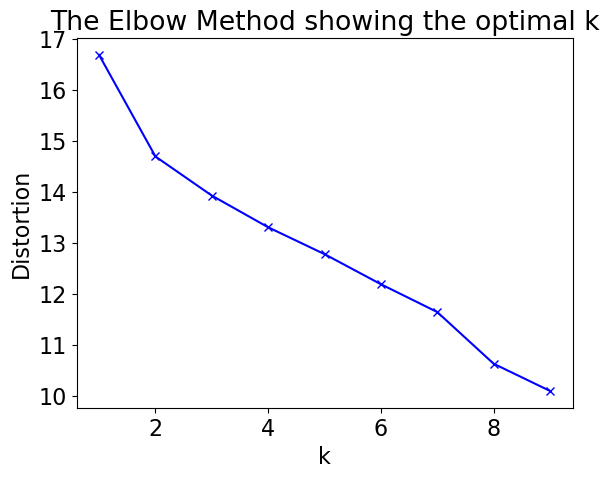

How many clusters for kMeans: 5
main fun 49
2
0
3
4
1


OSError: [Errno 22] Invalid argument: 'cluster_avg_traces_graph.png'

In [17]:
%%capture --no-stdout --no-display
def demo_main():
    plot_decision = input("plot the graphs? (y/n): ")
    concat_axis = input("specify axis for concatenating multiple trials [v=0][h=1][n]: ")
    plotting_dict = {}
    batched_original_data_dict, trial_names = get_batched_data(roi_paths)
    
#     get_concat_data(roi_paths, batched_original_data_dict)
#     return  total_trial_sorted_temporal_traces, total_trial_sorted_kept_rois, roi_len_dict

    batch_total_sorted_temporal_traces, batch_total_sorted_kept_rois, roi_len_dict = get_concat_data(roi_paths, batched_original_data_dict, trial_names)
    
#     batch_total_sorted_temporal_traces, batch_total_sorted_kept_rois, roi_len_dict = get_batched_total_sorted_rois(batched_original_data_dict, video_template)
    n_clusters = elbow_plot(batch_total_sorted_temporal_traces)
    batch_labelled_total_list, grouped_KMeans_dict = kMeans_clustering(batch_total_sorted_temporal_traces, batch_total_sorted_kept_rois, n_clusters)
    total_frames, trial_duration, trial_name = get_lims(video1_path, video1_name, roi1)
    
    plotting_dict['Batched_total_labels'] = batch_labelled_total_list
    plotting_dict['Batched_total_traces'] = batch_total_sorted_temporal_traces
    print("main fun " +str(len(plotting_dict['Batched_total_labels'])))
    label_dictionary, label_props = label_dict(plotting_dict)
    mean_dict = plot_cluster_avgs(label_dictionary, total_frames, trial_duration)
    
    plot_heatmap_clusters(label_props, label_dictionary,n_clusters, trial_duration)
    
    trial_roi_num = int(len(batch_labelled_total_list)/len(trial_names)) #finds number of rois per trial
    print("The length is", trial_roi_num, "and the type is", type(trial_roi_num))
    anatomical_label_counter = 0
    for i in range(len(trial_names)):
        trial_cluster_labels = batch_labelled_total_list[int(anatomical_label_counter):int(anatomical_label_counter+trial_roi_num)]
        if plot_decision == 'y':
            anatomical_cluster_plot(video_paths[i], roi_paths[i], video_names[i], trial_cluster_labels)
        anatomical_label_counter += trial_roi_num
    
    plt.close()
    
    return plotting_dict, batched_original_data_dict, trial_names, batch_total_sorted_temporal_traces, batch_total_sorted_kept_rois, roi_len_dict, n_clusters, batch_labelled_total_list, grouped_KMeans_dict, total_frames, trial_duration, trial_name, label_dictionary, label_props, mean_dict, trial_roi_num, trial_cluster_labels

#     return label_dictionary, batch_labelled_total_list, plotting_dict, grouped_KMeans_dict, label_props, batch_total_sorted_temporal_traces, n_clusters, mean_dict, total_frames, trial_duration, batched_original_data_dict, roi_len_dict
# label_dictionary, batch_labelled_total_list, plotting_dict, grouped_KMeans_dict, label_props, batch_total_sorted_temporal_traces, n_clusters, mean_dict, total_frames, trial_duration, batched_original_data_dict, roi_len_dict = demo_main()
plotting_dict, batched_original_data_dict, trial_names, batch_total_sorted_temporal_traces, batch_total_sorted_kept_rois, roi_len_dict, n_clusters, batch_labelled_total_list, grouped_KMeans_dict, total_frames, trial_duration, trial_name, label_dictionary, label_props, mean_dict, trial_roi_num, trial_cluster_labels = demo_main()

In [ ]:
def main():
#     plotting_dict = {}
#     data_retrieval                                    #done
#         get file names                                #done
#         get data from files                           #done
#     data_sorting                                      #done
#         sort data by z score per plane                #done
#         store sorted temporal data                    #done
#     elbow_plotting                                    #
#         elbow plot of data to be k-means              #
#     k_means_cluster                                   #done
#         k-means clustering on whatever scope of data  #done
#         store clusters/ labels                        #done
#     plot_activity                                     #done
#         plot heatmap of clusters                      #done
#     plot_anatomy                                      #done
#         plot labeled image                            #done
#     save figures                                      #done
#     #use dict.update() to create the mega dictionary with everything nested appropriately
    plotting_dict = {}
    
    batched_original_data_dict, trial_names = get_batched_data(roi_paths)
    batch_total_sorted_temporal_traces, batch_total_sorted_kept_rois = get_batched_total_sorted_rois(batched_original_data_dict, video_template)
    n_clusters = elbow_plot(batch_total_sorted_temporal_traces)
    batch_labelled_total_list, grouped_KMeans_dict = kMeans_clustering(batch_total_sorted_temporal_traces, batch_total_sorted_kept_rois, n_clusters)
    total_frames, trial_duration, trial_name = get_lims(video1_path, video1_name, roi1)

    plotting_dict['Batched_total_labels'] = batch_labelled_total_list
    plotting_dict['Batched_total_traces'] = batch_total_sorted_temporal_traces
    label_dictionary, label_props = label_dict(plotting_dict)
    plot_heatmap_clusters(label_props, label_dictionary)
    
    label_dictionary = label_dict(plotting_dict)


The following functions are all for post plotting analysis

In [ ]:
def plot_GSScluster_demos(label_dictionary, total_frames, trial_duration):
    '''Plots a line graph of the average calcium activity of each cluster.'''
#     Things to fix:
#         Also could use a better name saving convention ie. trial name
    trace_counter = 0
    mean_dict = {}
    for i in label_dictionary:
        mean_dict[i] = np.mean(label_dictionary[i], axis=0)
        
    colors = ['red', 'green', 'blue', 'yellow', 'skyblue', 'magenta']
    xVals = np.linspace(0, trial_duration, total_frames)
    legend_names = mean_dict.keys()
#     fig = plt.figure(figsize=(30, 25), dpi=200)
    for i in (mean_dict.keys()):
#         print(i)
        plt.plot(xVals, mean_dict[i], color=colors[i])
#     plt.legend(legend_names)
#     plt.show()
#     plt.plot(mean_dict)
#     ax.spines['top'].set_visible(False)
#     plt.xlabel("Time (s)")
#     plt.ylabel("Z score")
    plt.savefig("GSSScluster_avg_traces_graph.png")
#     return mean_dict
plot_GSScluster_demos(label_dictionary, total_frames, trial_duration)

In [ ]:
#Objective of this cell is to find the trace of a neuron in the cluster where it has been plotted
# What I need:
#     how do I plot the clusters
#     a way to figure out the identity of a neuron in a slice:
#         how many neurons are in a slice
# replot the clusters with a marker beside where the neuron is
# plot the line of the neuron
# Interactive

#################################################
# Mar.5.20_HUC6f_8dpf_WFtoBF_1C-1_mc   is the one to use!!!!!!!!!!!!!!!!!!!!!!!!! esp slice 6
##################################################

def id_plotted_to_kcluster(roi_len_dict, batch_total_sorted_temporal_traces, batch_labelled_total_list):
#     roiCount = 0
#     roi_len_dict = {}
    trial_name = input("What is the trial name (A,B,C, etc.) of the neuron in question? ")
    trial_slice = int(input("What slice (starting at index 0) can the neuron be found on? "))
    trial_roi = int(input("What is the roi you want the trace for? "))
    if len(trial_name) > 1 or type(trial_slice) != int:
        print("You goober, recheck your values")
        input("press enter to progress")
#     for trial in batched_original_data_dict:
#         for z in range(video.shape[1]):
#             kept_rois = [ i for i in range(batched_original_data_dict[trial][0][z].shape[0]) if i not in batched_original_data_dict[trial][1][z]]
# #             roi_list.append(len(kept_rois))
#             if trial not in roi_len_dict.keys():
#                 roi_len_dict[trial] = [len(kept_rois)]
#             else:
#                 roi_len_dict[trial].append(len(kept_rois))
    held_roi = 0
    hold_num = 0
    
    for i in roi_len_dict:
#         print(i)
        for z in range(len(roi_len_dict[i])):
#             print(roi_len_dict[i][z])
            if i == trial_name and z == trial_slice:
#                 print('Held roi is', held_roi )
                held_roi = hold_num + trial_roi
                print('hello')
#                 print('held_roi is', held_roi)
            hold_num += roi_len_dict[i][z]
#             print("ROI len for the plane is", roi_len_dict[i][z])
#             print("hold num is", hold_num)
    
    
    if len(trial_name) == 1:
        plt.plot(batch_total_sorted_temporal_traces[held_roi], color = [0, 0, 1])
#         plt.plot(batch_total_sorted_temporal_traces[245], color = [1, 0, 0])
    else:
        print("invalid values")
    print("The held roi is ", str(held_roi))
    print("The held roi cluster is", str(batch_labelled_total_list[held_roi]))
#     return roi_len_dict
#     print(np.sum(roi_list[20:30]))
            


In [ ]:
id_plotted_to_kcluster(roi_len_dict, batch_total_sorted_temporal_traces, batch_labelled_total_list)

In [ ]:
print(batch_labelled_total_list[60:75])

In [ ]:
# temp_roi_arr = np.array(temp_roi_list)
# plt.plot(batched_temporal_traces)
print(trial_cluster_labels[18:39])
print(batch_labelled_total_list[244:276])

In [ ]:
new_arr = np.where(temp_roi_arr%2 ==0, temp_roi_arr, 1)
print(new_arr)

In [ ]:
[1,2,3,4,5,6,7]

In [ ]:
def info_dict_fun(trial_names, roi_len_dict):
    '''Provides relevant information for each trial including:
    Number of rois
    Response(y/n)
    
    '''
    roi_len_dict = {}
    for trial in batched_original_data_dict:
        for z in range(video_template.shape[1]):
            kept_rois = [ i for i in range(batched_original_data_dict[trial][0][z].shape[0]) if i not in batched_original_data_dict[trial][1][z]]
#             roi_list.append(len(kept_rois))
            if trial not in roi_len_dict.keys():
                roi_len_dict[trial] = [len(kept_rois)]
            else:
                roi_len_dict[trial].append(len(kept_rois))
                
    info_dict = {}
    for i in trial_names:
        num_trial_rois = sum(roi_len_dict[i])
        info_dict[i] = {'num_trial_rois':num_trial_rois}
    return info_dict
    

In [ ]:
# activity changes within fish function
# '''look for changes in activity profiles of neurons between trials of same fish.
# Assumes that all trials are already from the same fish.'''
# get k-means clustered labels
#         batch_labelled_total_list, grouped_KMeans_dict  
# get behaviour for each trial
# get number of ROIs per trial AND number of trials
# split clustered labels by number of trials
def cluster_proportion_changes(info_dict, batch_labelled_total_list, n_clusters):
    info_dict = info_dict
    batch_labelled_total_list = batch_labelled_total_list
    clustered_data = {}
    total_roi_num = 0
    for i in info_dict.keys():
        roi_labels = batch_labelled_total_list[total_roi_num:(total_roi_num+info_dict[i]['num_trial_rois'])]
        total_roi_num += info_dict[i]['num_trial_rois']
        
        info_dict[i].update({'roi_labels':roi_labels})
        counts = Counter(roi_labels)
        print(counts)
        proportions = {}
        for j in counts:
            proportions[j] = counts[j]/info_dict[i]['num_trial_rois']
        info_dict[i].update({'proportions':proportions})
        
        for k in range(0,n_clusters):
            if k not in info_dict[i]['proportions']:
                info_dict[i]['proportions'][k]=0
    return info_dict
        


In [ ]:
def proportions_delta_graph(info_dict):
    '''Currently plots for differences in proportions between trials of the same fish'''
    info_dict = info_dict
    resp_noresp = input('plot by response? y/n: ')
    
    colors = ['red', 'green', 'blue', 'goldenrodyellow', 'skyblue', 'magenta']
    cnum = 0
    legend_names = info_dict.keys()
    ax = plt.subplot(111)
    for i in info_dict.keys():
        lists = sorted(info_dict[i]['proportions'].items())     
        x,y = zip(*lists)
        ax.scatter(x,y, color=colors[cnum])
        cnum +=1
        
    plt.legend(legend_names)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xlabel('Cluster #')
    plt.ylabel('Proportion %')
    plt.xticks([0,1,2,3,4])
    plt.show()

In [ ]:
info_dict = info_dict_fun(trial_names, roi_len_dict)
new_dict = cluster_proportion_changes(info_dict, batch_labelled_total_list, n_clusters)
proportions_delta_graph(info_dict)

In [ ]:
##Silhuoette score still under development
def get_silhouette_scores():
    X = batch_total_sorted_temporal_traces
    new_error_list = []
    K= range(1,7)
    for k in K:
        clusterer = KMeans(n_clusters=n_clusters)#, random_state=10)
#         cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, batch_labelled_total_list)
        new_error_list += ["For K = " +str(k) +str(silhouette_avg)]
        print(silhouette_avg)
    return(new_error_list)


# >>> from tslearn.generators import random_walks
# >>> from tslearn.metrics import cdist_dtw
# >>> numpy.random.seed(0)
# >>> X = random_walks(n_ts=20, sz=16, d=1)
# >>> labels = numpy.random.randint(2, size=20)
# >>> silhouette_score(X, labels, metric="dtw")  # doctest: +ELLIPSIS
# 0.13383800...
# >>> silhouette_score(X, labels, metric="euclidean")  # doctest: +ELLIPSIS
# 0.09126917...
# >>> silhouette_score(X, labels, metric="softdtw")  # doctest: +ELLIPSIS
# 0.17953934...
# >>> silhouette_score(X, labels, metric="softdtw",
# ...                  metric_params={"gamma": 2.})     # doctest: +ELLIPSIS
# 0.17591060...
# >>> silhouette_score(cdist_dtw(X), labels,
# ...                  metric="precomputed")  # doctest: +ELLIPSIS
# 0.13383800...


# # new_error = get_silhouette_scores()


# # from sklearn.cluster import KMeans
# # import sklearn.preprocessing
# # import sklearn.decomposition #for PCA
# # from sklearn.metrics import silhouette_samples, silhouette_score

# # https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

In [ ]:
print(new_error)
x_vals = [2,3,4,5,6,7,8]
plt.plot(x_vals, new_error)

In [ ]:
arr_clust = np.array(to_cluster)

In [ ]:
groupA = [7,7,7,7,7,14,14,14] #r
groupB = [3,3,3,3,3,3,3,3] #b
groupC = [50,50,50,10,10,50,50,50] #g
groupD = [30,20,3,3,3,8,8,8] #magenta
groupE = [1,2,3,4,5,6,7,8] #y
to_cluster = [groupE, groupA, groupA, groupD, groupB, groupC, groupA, groupC, groupB, groupC, groupA, groupC, groupB, groupC, groupB, groupA, groupD]
label_cols = ['yellow', 'red', 'red', 'magenta', 'blue', 'green', 'red', 'green', 'blue', 'green', 'red', 'green', 'blue', 'green', 'blue', 'red', 'magenta']

def test_kMeans_clustering(a_cluster, n_clusters):
    kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters)
    clustered_data = kmeans.fit(a_cluster)

    test_labelled_total_list = kmeans.labels_
    return test_labelled_total_list
    
#     grouped_KMeans_dict = {}
#     for label, roi_ident in zip(batch_labelled_total_list, batch_total_sorted_kept_rois):
#         if label not in grouped_KMeans_dict:
#             roi_list = [roi_ident]
#             grouped_KMeans_dict[label] = roi_list
#         else:
#             roi_list = [roi_ident]
#             grouped_KMeans_dict[label] = grouped_KMeans_dict[label] + roi_list
    print(test_labelled_total_list)
#     return batch_labelled_total_list, grouped_KMeans_dict     
# test_labelled_list = test_kMeans_clustering(to_cluster, 3)
# my   result - array([5, 1, 1, 4, 2, 3, 1, 3, 2, 3, 1, 3, 2, 3, 2, 1, 4]
# tsne result - array([1, 0, 2, 2, 4, 3, 3, 1, 3, 2, 0, 3, 4, 1, 0, 1, 1])
# orig result - array([4, 0, 0, 3, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 2, 0, 3])

In [ ]:
to_cluster

In [ ]:
to_cluster[0:3]

In [ ]:
arr_clust.shape
arr_clust2 = [arr_clust, arr_clust]
arr_clust1 = [arr_clust]
arr_clust2 = np.array(arr_clust2)
arr_clust1 = np.array(arr_clust1)
arr_clust2.shape
arr_clust1.shape
arr_clust2

In [ ]:
from sklearn.manifold import TSNE
# import pandas as pd
# import seaborn as sns
X = pdf1
y= label_cols
 
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(X)
print(tsne_result.shape)
# (1000, 2)
# Two dimensions for each of our images
 
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1]})#, 'label': y})
# fig, ax = plt.subplots(1)
plt.scatter(x='tsne_1', y='tsne_2')#, c=y)
# sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
# lim = (tsne_result.min()-5, tsne_result.max()+5)
# ax.set_xlim(lim)
# ax.set_ylim(lim)
# ax.set_aspect('equal')
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [ ]:
print(tsne_result)

In [ ]:
# ax=plt.subplot(111)
xcoords = []
ycoords = []
for i in tsne_result:
    lists = i
#         print(lists)
    x,y = zip(lists)
#         ax.scatter(x,y, color=colors[cnum])
#         cnum +=1
#     print(len(x))
    xcoords.append(x)
    ycoords.append(y)
#     xcoords.extend(int(list(x)))
#     ycoords.extend(int(list(y)))
plt.scatter(xcoords,ycoords)
plt.show()
# print(xcoords)

In [ ]:
# groupA = [7,7,7,7,7,14,14,14] #r
# groupB = [3,3,3,3,3,3,3,3] #b
# groupC = [50,50,50,10,10,50,50,50] #g
# groupD = [30,20,3,3,3,8,8,8] #magenta
# groupE = [1,2,3,4,5,6,7,8] #y
# groupA2 = [7,7,5,7,7,14,14,14] #r
# groupB2 = [3,3,4,3,3,3,3,3] #b
# groupC2 = [50,50,40,10,10,50,50,50] #g
# groupD2 = [30,20,3,5,3,5,8,8] #magenta
# groupE2 = [1,2,3,4,2,6,7,8] #y
# groupA3 = [7,7,7,1,7,14,14,14] #r
# groupB3 = [3,3,1,3,3,3,3,3] #b
# groupC3 = [50,40,50,10,10,50,50,50] #g
# groupD3 = [30,20,3,1,3,8,8,8] #magenta
# groupE3 = [1,2,3,4,5,6,8,8] #y
# PCA_to_cluster = [groupE, groupA, groupA2, groupD, groupB, groupC, groupA3, groupC2, groupB3, groupC3, groupA, groupC2, groupB2, groupC, groupB, groupA2, groupD3]
# label_cols = ['yellow', 'red', 'red', 'magenta', 'blue', 'green', 'red', 'green', 'blue', 'green', 'red', 'green', 'blue', 'green', 'blue', 'red', 'magenta']
norm_to_cluster = sklearn.preprocessing.normalize(pseudodf)

In [ ]:
# # To getter a better understanding of interaction of the dimensions
# # plot the first three PCA dimensions
# fig = plt.figure(1, figsize=(8, 6))
# ax = Axes3D(fig, elev=-150, azim=110)
# X_reduced = PCA(n_components=3).fit_transform(iris.data)
# ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
#            cmap=plt.cm.Set1, edgecolor='k', s=40)
# ax.set_title("First three PCA directions")
# ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])
# ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])
# ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])
ax=plt.subplot(111)
X_reduced = sklearn.decomposition.PCA(n_components=2).fit_transform(pdf1)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1])#, X_reduced[:, 2])#, c=y,
#            cmap=plt.cm.Set1, edgecolor='k', s=40)

In [ ]:
X_reduced

In [ ]:
print(PCA_to_cluster.explained_variance_ratio_)

In [ ]:
pca_2 = sklearn.decomposition.PCA(n_components=2)
pca_2_result = pca_2.fit_transform(pdf1)
print('Explained Variation per pc: {}'.format(pca_2.explained_variance_ratio_))

In [ ]:
# testing tsne vs PCA vs no dimensionality reduction on z scored data
# get data
df = np.genfromtxt("C:/Users/mmart/Documents/Programming/Demos&Practice/15diff_calcium_traces.csv", delimiter=',')#, skip_header=1)
# z score data

# T-sne data

# PCA Data

# plot all

In [ ]:
pdf = pd.read_csv("C:/Users/mmart/Documents/Programming/Demos&Practice/15diff_calcium_traces.csv")

In [ ]:
pdf.head()

In [ ]:
pdf1 = pd.read_csv("C:/Users/mmart/Documents/Programming/Demos&Practice/15diff_calcium_traces.csv", index_col=0)

pseudodf = pd.read_csv("C:/Users/mmart/Documents/Programming/Demos&Practice/pseudocalcium_traces.csv")



In [ ]:
pseudodf.head()

In [ ]:
pdf1_norm = test_kMeans_clustering(a_cluster=norm_to_cluster, n_clusters=4)


In [ ]:
print(pdf1_norm)

In [ ]:
# pdf1_norm cluster is            [3 4 2 1 1 1 0 2 0 2 2 0 0 0 1]
# pdf1_tsne cluster is            [4 1 3 1 3 4 4 2 0 0 1 2 1 3 0]
# pdf1_tsne_normalized cluster is [2 1 0 1 0 2 4 4 3 2 1 3 4 3 0]
# pdf1_PCA cluster is             [1 3 0 0 0 0 2 4 2 4 0 2 2 2 0]
# pdf1_PCA_normalized cluster is  [4 2 2 3 1 1 0 2 0 1 2 0 0 0 3]
# TSKmeans cluster is             [2 4 1 0 3 3 1 1 1 3 3 1 1 1 0]
# TSKmeans_norm cluster is        [2 2 4 1 1 1 0 2 2 1 0 0 0 0 3]

# vv Test for 4 clusters in psuedo calcium trials vv

# ground truth                   [0 1 0 0 2 0 2 3 3 1 0 1 3 3 2]
# TSKmeans_norm cluster CHANGED  [0 1 0 0 2 0 2 3 3 1 0 1 3 3 2] ***********
# TSzscore cluster is CHANGED    [0 1 0 0 2 0 2 3 3 1 0 1 3 3 2] ***********

# KMeans_norm cluster CHANGED    [0 1 2 0 1 2 1 3 3 1 0 1 3 3 1]

5 clusters is [0, 1, 0, 0, 2, 0, 2, 3, 3, 1, 0, 1, 3, 3, 2]
# TSKmeans_norm cluster is        [1 3 1 1 0 1 0 2 2 3 1 3 2 2 0]
# KMeans_norm cluster is          [2 1 3 2 1 3 1 0 0 1 2 1 0 0 1]
# TSzscore cluster is               [2 0 2 2 3 2 3 1 1 0 2 0 1 1 3]

In [ ]:
# from tslearn.metrics import dtw
# dtw_score = dtw(x, y)

# https://databricks.com/blog/2019/04/30/understanding-dynamic-time-warping.html
# http://www1.cs.columbia.edu/~jopa/Papers/PaparrizosSIGMOD2015.pdf
# http://alexminnaar.com/2014/04/16/Time-Series-Classification-and-Clustering-with-Python.html

from tslearn.clustering import TimeSeriesKMeans


In [ ]:
model = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=10)
DTWtest = model.fit_predict(zscoreAll)

In [ ]:
DTWtest

In [ ]:
# pseudodf

zscoreNum = pseudodf.mean(axis=1)
zscoreDen = pseudodf.std(axis=1)
zscoreNumList = list(zscoreNum)
zscoreDenList = list(zscoreDen)
newNum = pseudodf.subtract(zscoreNumList, axis=0)
zscoreAll = newNum.divide(zscoreDenList, axis=0)

In [ ]:
for z in range(video.shape[1]):                
    kept_rois = [ i for i in range(batched_original_data_dict[trial][0][z].shape[0]) if i not in batched_original_data_dict[trial][1][z]]

    zscoreNum = temporal_footprints[z][kept_rois] - np.mean(temporal_footprints[z][kept_rois], axis=1)[:, np.newaxis]
    zscorePreDen = np.std(temporal_footprints[z][kept_rois], axis=1)[:, np.newaxis]
    preDenBoolArr = np.isnan(zscorePreDen)
    mmzscoreDen = np.where(zscorePreDen != 0, zscorePreDen, 1)# replaces 0 with 1 so the denominator isn't 0
    zscore = zscoreNum / mmzscoreDen


In [ ]:
def test_silhouette_scores(to_cluster):
    X = to_cluster
    new_error_list = []
    silhouette_list = []
    K= range(2,9)
    for k in K:
#         clusterer = KMeans(n_clusters=k, random_state=10)
#         cluster_labels = clusterer.fit_predict(X)
        model = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=10)
        labels = model.fit_predict(X)
        s_score = silhouette_score(X, labels, metric="dtw")
        print('Silhouette score for '+str(k)+ 'is '+ str(s_score))
        
        
# #         print(cluster_labels)
#         silhouette_avg = silhouette_score(X, cluster_labels)
# # #         silhouette_avg = silhouette_score(X, cluster_labels)# test_labelled_list)
# #         new_error_list += [str(k) +" Is K = " +str(silhouette_avg)]
# #         print(silhouette_avg)
#         silhouette_list.append(silhouette_avg)
#     return silhouette_list
#     return(new_error_list)

# model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=10)
#     batch_labelled_total_list = model.fit_predict(batch_total_sorted_temporal_traces)

# new_error = test_silhouette_scores()

# >>> from tslearn.generators import random_walks
# >>> from tslearn.metrics import cdist_dtw
# >>> numpy.random.seed(0)
# >>> X = random_walks(n_ts=20, sz=16, d=1)
# >>> labels = numpy.random.randint(2, size=20)
# >>> silhouette_score(X, labels, metric="dtw")  # doctest: +ELLIPSIS
# 0.13383800...
# >>> silhouette_score(X, labels, metric="euclidean")  # doctest: +ELLIPSIS
# 0.09126917...
# >>> silhouette_score(X, labels, metric="softdtw")  # doctest: +ELLIPSIS
# 0.17953934...
# >>> silhouette_score(X, labels, metric="softdtw",
# ...                  metric_params={"gamma": 2.})     # doctest: +ELLIPSIS
# 0.17591060...
# >>> silhouette_score(cdist_dtw(X), labels,
# ...                  metric="precomputed")  # doctest: +ELLIPSIS
# 0.13383800...


In [ ]:
def plot_silhouette(to_cluster):
    plt.close()
    X = to_cluster
    new_error_list = []
    silhouette_list = []
    K= range(2,9)    
    for k in K:
        fig, (ax1, ax2) = plt.subplots(1,2)
        fig.set_size_inches(18, 7)
#         ax1.set_xlim([-0.5, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (len(K) + 1) * 10])
        model = TimeSeriesKMeans(n_clusters=k, metric="dtw", max_iter=10)
        labels = model.fit_predict(X)
        s_score = silhouette_score(X, labels, metric="dtw")
        sample_silhouette_values = silhouette_samples(X, labels)
        y_lower = 10
        for i in K:
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / len(K))
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=s_score, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
#         ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        
    plt.show()

        
        
        

In [ ]:
plot_silhouette(zscoreAll)

In [ ]:
asd = [1,2,3,4]
sdf = [2,3,4,5]
dfg = [3,4,5,6]
fgh = [4,5,6,7]
lisarr = np.array((asd,sdf, dfg, fgh))
lislis = list(asd+sdf+ dfg+ fgh)
as1 =[11,12,13,14]
sd1 = [12,13,14,15]
df1 = [13,14,15,16]
fg1 = [14,15,16,16]
lisarr1 = np.array((as1,sd1,df1,fg1))
# lislis11 = list(as1,sd1,df1,fg1)


In [ ]:
lisorig = []
lisorig.append(asd)

In [ ]:
print(lisorig)
lisorig.append(sdf)
lisorig.append(dfg)
lisorig.append(fgh)

In [ ]:
lisorig_arr = np.array(lisorig)

In [ ]:
# or0= np.concatenate((lisarr, lisarr1))
# or1= np.concatenate((lisarr, lisarr1), axis=1)
or1 = np.concatenate((or1, lisarr1), axis=1)

In [ ]:
ts1z1 = [1,2,3,4,2,3,4,5]
ts1z2 = [2,3,4,5,1,2,3,4]
ts1z3 = [1,2,3,4,1,2,3,4]
ts2z1 = [12,13,14,15,13,14,15,16]
ts2z2 = [13,14,15,16,12,13,14,15]
ts2z3 = [12,13,14,15,12,13,14,15]
ts1 = []
ts2 = []
ts1.append(ts1z1)
ts1.append(ts1z2)
ts1.append(ts1z3)
ts2.append(ts2z1)
ts2.append(ts2z2)
ts2.append(ts2z3)
sd1 = [12,13,14,15]
df1 = [13,14,15,16]

In [ ]:
def get_concat_data(roi_paths):
    j=0
    for k in roi_paths:
        rois = np.load(k, allow_pickle=True)
        temporal_footprints = rois[()]['roi_temporal_footprints']
        removed_rois = rois[()]['all_removed_rois']
        trial_rois = []
        for z in range(video_template.shape[1]):
            kept_rois = [i for i in range(temporal_footprints[z].shape[0]) if i not in removed_rois[z]]
            tseries = temporal_footprints[z][kept_rois]
            trial_rois.append(tseries)
#             print('The length of the time series is ', len(tseries[0]))
#             print('The length of the trial rois is ', len(trial_rois))
        print(len(trial_rois))
        print(len(trial_rois[0]))
        trial_arr = np.array(trial_rois)
        trial_arr.reshape(10,110)
        print('the shape of trial_arr is ', trial_arr.shape)
#         print(trial_arr)
        
        if j!= 0:
            concat_arr = np.concatenate((concat_arr, trial_arr), axis=1)
            print('in if statement, j is ', j)
        elif j == 0:
            concat_arr = trial_arr
            print('in elif statement, j is ', j)
        j+=1
        

In [ ]:
testList = ['a', 'b', 'c', 'd']
mydict = {}
mydict[str(testList)] = 12


In [ ]:
j=0
for i in mydict:
    print(j)
    j+=1

In [ ]:
print(len(mydict.keys()))